# Identificação de Cargas através de Representação Visual de Séries Temporais

* `Artigo:` Imaging NILM Time-series
* `URL`: https://link.springer.com/chapter/10.1007/978-3-030-20257-6_16
* `Source-code`: https://github.com/LampriniKyrk/Imaging-NILM-time-series
* `Estratégia proposta`: converter série-temporal em imagens, extrair características com DNN (VG16) e classificação supervisionada.

# Carregando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys
from math import *
from pprint import pprint
from tqdm import tqdm_notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

REDD_RESOURCES_PATH = 'datasets/REDD'
BENCHMARKING_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'

sys.path.append(os.path.join(BENCHMARKING_RESOURCES_PATH, ''))

from serie2QMlib import *

# Pré-processamento dos dados 

In [2]:
# Define sliding window
def window_time_series(series, n, step=1):
    #    print "in window_time_series",series
    if step < 1.0:
        step = max(int(step * n), 1)
    return [series[i:i + n] for i in range(0, len(series) - n + 1, step)]

# PAA function
def paa(series, now, opw):
    if now == None:
        now = len(series) / opw
    if opw == None:
        opw = ceil(len(series) / now)
    return [sum(series[i * opw: (i + 1) * opw]) / float(opw) for i in range(now)]


def standardize(serie):
    dev = np.sqrt(np.var(serie))
    mean = np.mean(serie)
    return [(each - mean) / dev for each in serie]

# Rescale data into [0,1]
def rescale(serie):
    maxval = max(serie)
    minval = min(serie)
    gap = float(maxval - minval)
    return [(each - minval) / gap for each in serie]

# Rescale data into [-1,1]
def rescaleminus(serie):
    maxval = max(serie)
    minval = min(serie)
    gap = float(maxval - minval)
    return [(each - minval) / gap * 2 - 1 for each in serie]


# Generate quantile bins
def QMeq(series, Q):
    q = pd.qcut(list(set(series)), Q)
    dic = dict(zip(set(series), q.labels))
    MSM = np.zeros([Q, Q])
    label = []
    for each in series:
        label.append(dic[each])
    for i in range(0, len(label) - 1):
        MSM[label[i]][label[i + 1]] += 1
    for i in xrange(Q):
        if sum(MSM[i][:]) == 0:
            continue
        MSM[i][:] = MSM[i][:] / sum(MSM[i][:])
    return np.array(MSM), label, q.levels


# Generate quantile bins when equal values exist in the array (slower than QMeq)
def QVeq(series, Q):
    q = pd.qcut(list(set(series)), Q)
    dic = dict(zip(set(series), q.labels))
    qv = np.zeros([1, Q])
    label = []
    for each in series:
        label.append(dic[each])
    for i in range(0, len(label)):
        qv[0][label[i]] += 1.0
    return np.array(qv[0][:] / sum(qv[0][:])), label


# Generate Markov Matrix given a spesicif number of quantile bins
def paaMarkovMatrix(paalist, level):
    paaindex = []
    for each in paalist:
        for k in range(len(level)):
            lower = float(level[k][1:-1].split(',')[0])
            upper = float(level[k][1:-1].split(',')[-1])
            if each >= lower and each <= upper:
                paaindex.append(k)
    return paaindex


# Generate Image (.png) files of generated images
def gengramImgs(image, paaimages, label, name, path):
    import operator
    index = zip(range(len(label)), label)
    index.sort(key=operator.itemgetter(1))
    count = 0
    for p, q in index:
        count += 1
        #print 'generate fig of pdfs:', p
        plt.ioff();
        fig = plt.figure();
        fig.set_size_inches((1,1))
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.imshow(paaimages[p], aspect='equal');
        plt.savefig(path+"/fig-"+name+".png")
        plt.close(fig)
        if count > 30:
            break

# Generate pdf files of trainsisted array in porlar coordinates
def genpolarpdfs(raw, label, name):
    import matplotlib.backends.backend_pdf as bpdf
    import operator
    index = zip(range(len(label)), label)
    index.sort(key=operator.itemgetter(1))
    with bpdf.PdfPages(name) as pdf:
        for p, q in index:
            #print 'generate fig of pdfs:', p
            plt.ioff();
            r = np.array(range(1, length + 1));
            r = r / 100.0;
            theta = np.arccos(np.array(rescaleminus(standardize(raw[p][1:])))) * 2;
            fig = plt.figure();
            plt.suptitle(datafile + '_' + str(label[p]));
            ax = plt.subplot(111, polar=True);
            ax.plot(theta, r, color='r', linewidth=3);
            pdf.savefig(fig)
            plt.close(fig)
    pdf.close


# return the max value instead of mean value in PAAs
def maxsample(mat, s):
    retval = []
    x, y, z = mat.shape
    l = np.int(np.floor(y / float(s)))
    for each in mat:
        block = []
        for i in range(s):
            block.append([np.max(each[i * l:(i + 1) * l, j * l:(j + 1) * l]) for j in xrange(s)])
        retval.append(np.asarray(block))
    return np.asarray(retval)


# Pickle the data and save in the pkl file
def pickledata(mat, label, train, name):
    #print '..pickling data:', name
    traintp = (mat[:train], label[:train])
    testtp = (mat[train:], label[train:])
    f = file('fridge/' + name + '.pkl', 'wb')
    pickletp = [traintp, testtp]
    cPickle.dump(pickletp, f, protocol=cPickle.HIGHEST_PROTOCOL)


def pickle3data(mat, label, train, name):
    #print '..pickling data:', name
    traintp = (mat[:train], label[:train])
    validtp = (mat[:train], label[:train])
    testtp = (mat[train:], label[train:])
    f = file(name + '.pkl', 'wb')
    pickletp = [traintp, validtp, testtp]
    cPickle.dump(pickletp, f, protocol=cPickle.HIGHEST_PROTOCOL)
    



## Parâmetros gerais dos dados utilizados na modelagem (treino e teste)

In [3]:
#################################
###Define the parameters here####
#################################

datafiles = ['dish washer1-1']  # Data file name (TODO: alterar aqui)
trains = [250]  # Number of training instances (because we assume training and test data are mixed in one file)
size = [32]  # PAA size
GAF_type = 'GADF'  # GAF type: GASF, GADF
save_PAA = True  # Save the GAF with or without dimension reduction by PAA: True, False
rescale_type = 'Zero'  # Rescale the data into [0,1] or [-1,1]: Zero, Minusone

directory = os.path.join(BENCHMARKING_RESOURCES_PATH, 'GeneratedImages') #the directory will be created if it does not already exist. Here the images will be stored
if not os.path.exists(directory):
    os.makedirs(directory)

## Gerando dados

A fim de normalizar os benchmarkings, serão utilizados os dados das séries do `bechmarking 1` para o processo de Extração de Características (conversão `serie2image` - *benchmarking 2*).

## Extração de Características

In [4]:
def serie2image(serie, GAF_type = 'GADF', scaling = False, s = 32):
    """
    Customized function to perform Series to Image conversion.
    
    Args:
        serie    : original input data (time-serie chunk of appliance/main data - REDD - benchmarking 1)
        GAF_type : GADF / GASF (Benchmarking 2 process)
        s        : Size of output paaimage originated from serie [ INFO: PAA = (32, 32) / noPAA = (50, 50) ]
    """
    image = None
    paaimage = None
    patchimage = None
    matmatrix = None
    fullmatrix = None

    std_data = serie
    if scaling:
        std_data = rescale(std_data)
    paalistcos = paa(std_data, s, None)
    # paalistcos = rescale(paa(each[1:],s,None))
    
    # paalistcos = rescaleminus(paa(each[1:],s,None))

    ################raw###################
    datacos = np.array(std_data)
    #print(datacos)
    datasin = np.sqrt(1 - np.array(std_data) ** 2)
    #print(datasin)

    paalistcos = np.array(paalistcos)
    paalistsin = np.sqrt(1 - paalistcos ** 2)

    datacos = np.matrix(datacos)
    datasin = np.matrix(datasin)

    paalistcos = np.matrix(paalistcos)
    paalistsin = np.matrix(paalistsin)
    if GAF_type == 'GASF':
        paamatrix = paalistcos.T * paalistcos - paalistsin.T * paalistsin
        matrix = np.array(datacos.T * datacos - datasin.T * datasin)
    elif GAF_type == 'GADF':
        paamatrix = paalistsin.T * paalistcos - paalistcos.T * paalistsin
        matrix = np.array(datasin.T * datacos - datacos.T * datasin)
    else:
        sys.exit('Unknown GAF type!')
        
    #label = np.asarray(label)
    image = matrix
    paaimage = np.array(paamatrix)
    matmatrix = np.asarray(matmatrix)
    fullmatrix = np.asarray(fullmatrix)
    #
    # maximage = maxsample(image, s)
    # maxmatrix = np.asarray(np.asarray([each.flatten() for each in maximage]))
    
    if save_PAA == False:
        finalmatrix = matmatrix
    else:
        finalmatrix = fullmatrix

    # uncomment below if needed data in pickled form
    # pickledata(finalmatrix, label, train, datafilename)

    #gengramImgs(image, paaimage, label, directory)
    
    return image, paaimage, matmatrix, fullmatrix, finalmatrix

In [2]:
# Reading power dataset (benchmark 1)
BENCHMARKING1_RESOURCES_PATH = "benchmarkings/cs446 project-electric-load-identification-using-machine-learning/"

size_paa = 32
size_without_paa = 30

# devices to be used in training and testing
use_idx = np.array([3,4,6,7,10,11,13,17,19])

label_columns_idx = ["APLIANCE_{}".format(i) for i in use_idx]

### Conjunto de Treino

Processing train dataset (Series to Images)...



Saving processed data...


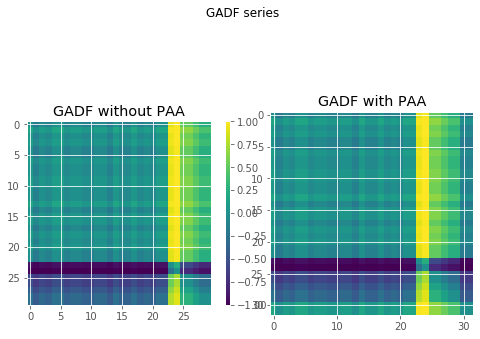

In [6]:
print("Processing train dataset (Series to Images)...")

# Train...
train_power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') )
train_labels_binary = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_labels_binary.npy') )

data_paa_train = []
data_without_paa_train = []

#for idx, row in tqdm_notebook(df_power_chunks.iterrows(), total = df_power_chunks.shape[0]):
for idx, power_chunk in tqdm_notebook(enumerate(train_power_chunks), total = train_power_chunks.shape[0]):

    #serie = row[attr_columns_idx].tolist()  
    #print(serie)
    #labels = row[label_columns_idx].astype('int').astype('str').tolist()
    serie = power_chunk
    labels = train_labels_binary[idx, :].astype('str').tolist()
    labels_str = ''.join(labels)
    
    for g_Type in ['GASF', 'GADF']:

        #image, paaimage, matmatrix, fullmatrix, finalmatrix = serie2image(serie, g_Type)
        image, paaimage, _, _, _ = serie2image(serie, g_Type, scaling=True)
        
        # Persist image data files (PAA - noPAA)
        np.save(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedMatrixImages", 
                "{}_WITHOUTPAA_{}_train_{}.npy".format(idx, g_Type, labels_str) 
            ), 
            image
        )
        # x is the array you want to save 
        imsave(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedImages", 
                "{}_WITHOUTPAA_{}_train_{}.png".format(idx, g_Type, labels_str) 
            ), 
            image
        )
        data_without_paa_train.append( list([idx, g_Type]) + list(image.flatten()) + list(labels) )
        
        np.save(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedMatrixImages", 
                "{}_PAA_{}_train_{}.npy".format(idx, g_Type, labels_str) 
            ), 
            paaimage
        )
        imsave(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedImages", 
                "{}_PAA_{}_train_{}.png".format(idx, g_Type, labels_str) 
            ),
            paaimage
        )
        data_paa_train.append( list([idx, g_Type]) + list(paaimage.flatten()) + list(labels) )

# VIsualizgin some results...
plt.figure(figsize=(8,6));

plt.suptitle(g_Type + ' series');
ax1 = plt.subplot(121);
plt.title(g_Type + ' without PAA');
plt.imshow(image);
divider = make_axes_locatable(ax1);
cax = divider.append_axes("right", size="2.5%", pad=0.2);
plt.colorbar(cax=cax);

ax2 = plt.subplot(122);
plt.title(g_Type + ' with PAA');
plt.imshow(paaimage);

print('Saving processed data...')
df_without_paa_train = pd.DataFrame(
    data = data_without_paa_train,
    columns = list(["IDX", "TYPE"]) + ["DIMESION_{}".format(d) for d in range(size_without_paa*size_without_paa)] + list(label_columns_idx)
)
df_without_paa_train.to_csv(os.path.join( BENCHMARKING_RESOURCES_PATH, "datasets", "df_without_paa_train.csv"))

df_paa_train = pd.DataFrame(
    data = data_paa_train,
    columns = list(["IDX", "TYPE"]) + ["DIMESION_{}".format(d) for d in range(size_paa*size_paa)] + list(label_columns_idx)
)
df_paa_train.to_csv(os.path.join( BENCHMARKING_RESOURCES_PATH, "datasets", "df_paa_train.csv"))

## Conjunto de teste

Processing test dataset (Series to Images)...



Saving processed data...


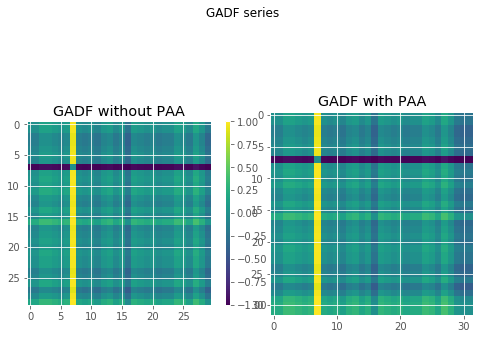

In [7]:
print("Processing test dataset (Series to Images)...")

# Test...
test_power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_power_chunks.npy') )
test_labels_binary = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_labels_binary.npy') )

data_paa_test = []
data_without_paa_test = []

#for idx, row in tqdm_notebook(df_power_chunks.iterrows(), total = df_power_chunks.shape[0]):
for idx, power_chunk in tqdm_notebook(enumerate(test_power_chunks), total = test_power_chunks.shape[0]):

    #serie = row[attr_columns_idx].tolist()  
    #print(serie)
    #labels = row[label_columns_idx].astype('int').astype('str').tolist()
    serie = power_chunk
    labels = test_labels_binary[idx, :].astype('str').tolist()
    labels_str = ''.join(labels)
    
    for g_Type in ['GASF', 'GADF']:

        #image, paaimage, matmatrix, fullmatrix, finalmatrix = serie2image(serie, g_Type)
        image, paaimage, _, _, _ = serie2image(serie, g_Type, scaling=True)
        
        # Persist image data files (PAA - noPAA)
        np.save(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedMatrixImages", 
                "{}_WITHOUTPAA_{}_test_{}.npy".format(idx, g_Type, labels_str) 
            ), 
            image
        )
        # x is the array you want to save 
        imsave(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedImages", 
                "{}_WITHOUTPAA_{}_test_{}.png".format(idx, g_Type, labels_str) 
            ), 
            image
        )
        data_without_paa_test.append( list([idx, g_Type]) + list(image.flatten()) + list(labels) )
        
        np.save(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedMatrixImages", 
                "{}_PAA_{}_test_{}.npy".format(idx, g_Type, labels_str) 
            ), 
            paaimage
        )
        imsave(
            os.path.join( 
                BENCHMARKING_RESOURCES_PATH, 
                "GeneratedImages", 
                "{}_PAA_{}_test_{}.png".format(idx, g_Type, labels_str) 
            ),
            paaimage
        )
        data_paa_test.append( list([idx, g_Type]) + list(paaimage.flatten()) + list(labels) )

# VIsualizgin some results...
plt.figure(figsize=(8,6));

plt.suptitle(g_Type + ' series');
ax1 = plt.subplot(121);
plt.title(g_Type + ' without PAA');
plt.imshow(image);
divider = make_axes_locatable(ax1);
cax = divider.append_axes("right", size="2.5%", pad=0.2);
plt.colorbar(cax=cax);

ax2 = plt.subplot(122);
plt.title(g_Type + ' with PAA');
plt.imshow(paaimage);

print('Saving processed data...')
df_without_paa_test = pd.DataFrame(
    data = data_without_paa_test,
    columns = list(["IDX", "TYPE"]) + ["DIMESION_{}".format(d) for d in range(size_without_paa*size_without_paa)] + list(label_columns_idx)
)
df_without_paa_test.to_csv(os.path.join( BENCHMARKING_RESOURCES_PATH, "datasets", "df_without_paa_test.csv"))

df_paa_test = pd.DataFrame(
    data = data_paa_test,
    columns = list(["IDX", "TYPE"]) + ["DIMESION_{}".format(d) for d in range(size_paa*size_paa)] + list(label_columns_idx)
)
df_paa_test.to_csv(os.path.join( BENCHMARKING_RESOURCES_PATH, "datasets", "df_paa_test.csv"))

# Modelagem

In [3]:
def metrics(test, predicted):
    ##CLASSIFICATION METRICS

    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    

    # print('f1:',f1)
    # print('acc: ',acc)
    # print('recall: ',rec)
    # print('precision: ',prec)

    # # to copy paste print
    #print("{:.4}\t{:.4}\t{:.4}\t{:.4}\t{:.4}".format(acc, prec, rec, f1, f1m))

    # ##REGRESSION METRICS
    # mae = mean_absolute_error(test_Y,pred)
    # print('mae: ',mae)
    # E_pred = sum(pred)
    # E_ground = sum(test_Y)
    # rete = abs(E_pred-E_ground)/float(max(E_ground,E_pred))
    # print('relative error total energy: ',rete)
    return acc, prec, rec, f1, f1m


def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show()
    return

def embedding_images(images, model):
    
    # Feature extraction process with VGG16
    vgg16_feature_list = [] # Attributes array (vgg16 embedding)
    y = [] # Extract labels from name of image path[]

    for path in tqdm_notebook(images):

        img = keras_image.load_img(path, target_size=(100, 100))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # "Extracting" features...
        vgg16_feature = vgg16_model.predict(x)
        vgg16_feature_np = np.array(vgg16_feature)
        vgg16_feature_list.append(vgg16_feature_np.flatten())

        # Image (chuncked serie) 
        file_name = path.split("\\")[-1].split(".")[0]
        image_labels = [int(l) for l in list(file_name.split("_")[-1])]
        y.append(image_labels)

    X = np.array(vgg16_feature_list)
    
    return X, y

## Benchmarking (replicando estudo)

In [4]:
# Building dnn model (feature extraction)
vgg16_model = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=(100, 100, 3), 
    pooling='avg',
    classes=1000
)

### *Embedding* das imagens de Treino

In [5]:
# GAFD Images with PAA (Train)
images = sorted(glob( 
    os.path.join(
        BENCHMARKING_RESOURCES_PATH, 
        "GeneratedImages",
        "*_PAA_GADF_train_*.png"
    ) 
))
X_train, y_train = embedding_images(images, vgg16_model)

# Data persistence
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/X_train.npy'), X_train)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/y_train.npy'), y_train)

### *Embedding* das imagens de Teste

In [6]:
# GAFD Images with PAA (Train)
images = sorted(glob( 
    os.path.join(
        BENCHMARKING_RESOURCES_PATH, 
        "GeneratedImages",
        "*_PAA_GADF_test_*.png"
    ) 
))
X_test, y_test = embedding_images(images, vgg16_model)

# Data persistence
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/X_test.npy'), X_test)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/y_test.npy'), y_test)

### Treinando Classificador Supervisionado

In [12]:
# Training supervised classifier
clf = DecisionTreeClassifier(max_depth=15)

# Train classifier
clf.fit(X_train, y_train)

# Save classifier for future use
#joblib.dump(clf, 'Tree'+'-'+device+'-redd-all.joblib')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Avaliando Classificador


RESULT ANALYSIS


ON/OFF State Charts
-------------------------------------------------------------------------------------------------------------------


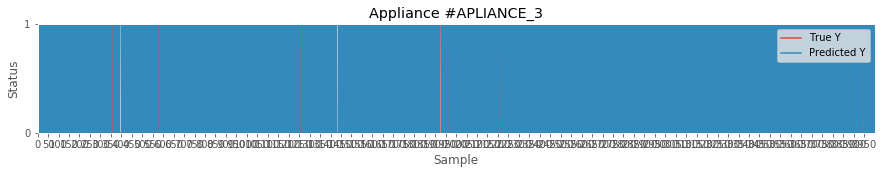

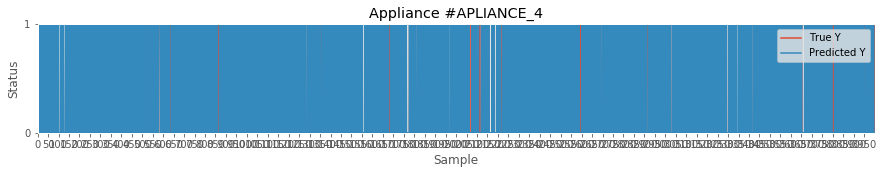

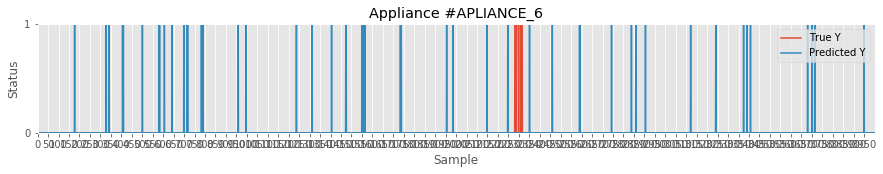

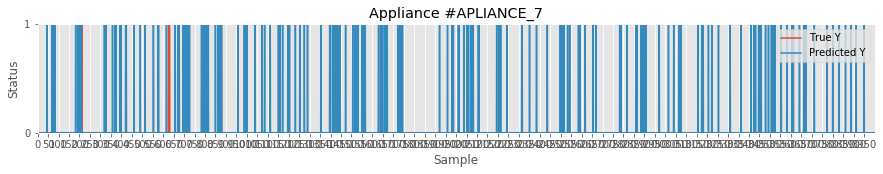

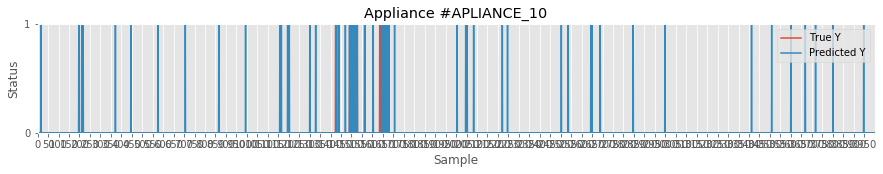

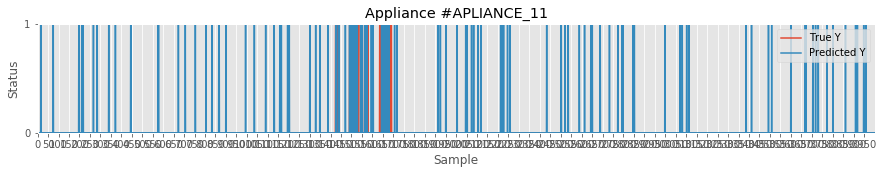

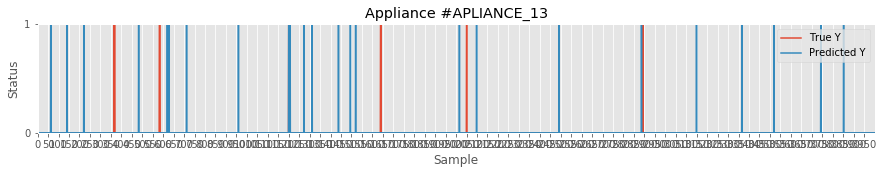

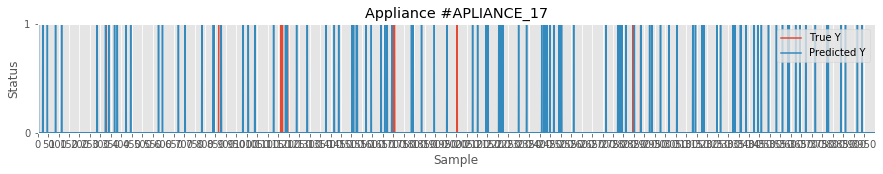

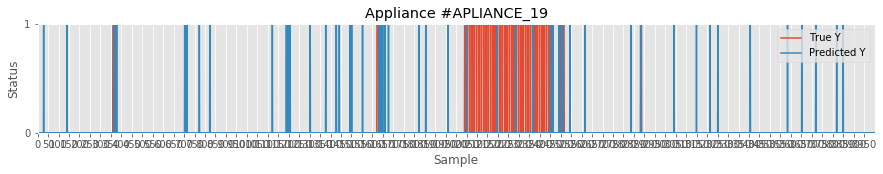

-------------------------------------------------------------------------------------------------------------------

FINAL PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro
0,APLIANCE_3,52.98,53.04,59.63,56.14,52.73
1,APLIANCE_4,59.72,52.20,41.86,46.46,57.09
2,APLIANCE_6,97.98,0.00,0.00,0.00,49.49
3,APLIANCE_7,94.88,3.57,30.43,6.39,51.88
4,APLIANCE_10,98.12,52.87,57.50,55.09,77.07
5,APLIANCE_11,95.62,34.03,37.98,35.90,66.82
6,APLIANCE_13,99.00,8.00,10.53,9.09,54.29
7,APLIANCE_17,96.32,1.79,5.13,2.65,50.39
8,APLIANCE_19,88.55,30.65,4.38,7.66,50.78



OVERALL AVERAGE PERFORMANCE:


,Metric,Result (%)
0,Accuracy,87.02
1,Precision,26.24
2,Recall,27.49
3,F1-score,24.38
4,F1-macro,56.73


In [13]:
# Predict test data
y_pred = clf.predict(X_test)

# Print metrics
final_performance = []
y_test = np.array(y_test)
y_pred = np.array(y_pred)

print("")
print("RESULT ANALYSIS\n\n")
print("ON/OFF State Charts")
print("-" * 115)
for i in range(y_test.shape[1]):
    
    fig  = plt.figure(figsize=(15, 2))
    plt.title("Appliance #{}".format( label_columns_idx[i]))
    plt.plot(y_test[:, i].flatten(), label = "True Y")
    plt.plot( y_pred[:, i].flatten(), label = "Predicted Y")
    plt.xlabel('Sample')
    plt.xticks(range(0, y_test.shape[0], 50))
    plt.xlim(0, y_test.shape[0])
    plt.ylabel('Status')
    plt.yticks([0, 1])
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    acc, prec, rec, f1, f1m = metrics(y_test[:, i], y_pred[:, i])
    final_performance.append([
        label_columns_idx[i], 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2)
    ])

print("-" * 115)
print("")
print("FINAL PERFORMANCE BY APPLIANCE (LABEL):")
df_metrics = pd.DataFrame(
    data = final_performance,
    columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro"]
)
display(df_metrics)

print("")
print("OVERALL AVERAGE PERFORMANCE:")
final_performance = np.mean(np.array(final_performance)[:, 1:].astype(float), axis = 0)
display(pd.DataFrame(
    data = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "F1-macro"],
        "Result (%)": [round(p, 2) for p in final_performance]
    }
))
# print("-----------------")
# print("Accuracy  : {0:.2f}%".format( final_performance[0] ))
# print("Precision : {0:.2f}%".format( final_performance[1] ))
# print("Recall    : {0:.2f}%".format( final_performance[2] ))
# print("F1-score  : {0:.2f}%".format( final_performance[3] ))
# print("F1-macro  : {0:.2f}%".format( final_performance[4] ))
# print("-----------------")

# Conclusões

Assim como no benchmarking 1, foi possível reproduzir a abordagem proposta no trabalho `Imaging NILM Time-Series`. Todavia, como esperado, alguns dados utilizados no estudo não foram disponibilizados, estando acessível apenas o código-fonte da abordagem, o que tomamos como base para realizar esse experimento. Com os códigos em mãos, implementei as mesmas rotinas dentro de um pipeline similar ao benchmarking 1, a fim de que o processos de **Geração de dados** e **Extração de Características** fosse <u>exatamente</u> os mesmos propostos nos trabalhos originais.

A partir desta perspectiva, visando inclusive potencializar um estudo comparativo entre Benchmarkinks e a Proposta do doutorado, utilizei os mesmos dados do Benchmarking anterior para a Geração de Imagens GAF e Extração de características com a rede VGG16 (abordagem proposta pelos autores). Por fim, a partir do pipeline implementado, foi treinado um classificador baseado em Árvore de Decisão (multilabel) e avaliado a performance do mesmo, considerando métricas tradicionais de abordagens supervisionadas de ML.

Portanto, a partir deste ponto, temos implementado e avaliado duas abordagens de referências, os quais permitiram exportar os dados, realizar o pré-processamento dos mesmos e extrair as características - cada um dentro de sua estratégia - para os dados da base REDD, permitindo estabelecer um cenário razoável de comparação para a classificação de séries temporais no contexto de NILM. Como próximos passos, está a definição dos cenários de testes (janela temporal, SEED, algoritmos de classificação, métricas de desempenho, etc.) e o consequente desenvolvimento da abordagem baseada em Gráfico de Recorrência para o problema de TSC, considerando os dados da residência 1 da base REDD.